In [171]:
# imports

import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# ignore chained assignment warning in pandas
pd.set_option('mode.chained_assignment', None)


In [132]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#63B9FF', '#FFB1CA', '#4F1DD7']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 300


# import data

In [240]:
# read in data 

pro_cv_df = pd.read_csv('../../data/4-fitting/pro/cv_data.csv')
syn_cv_df = pd.read_csv('../../data/4-fitting/syn/cv_data.csv')

# combine and sort dataframes
pro_cv_df['genus'] = 'pro'
syn_cv_df['genus'] = 'syn'
combo_df = pd.concat([pro_cv_df, syn_cv_df])
combo_df = combo_df.sort_values(['genus', 'bootstrap_id', 'rank', 'lambda', 'replicate_pair'])

# limit dataset to values of interest
df = combo_df[combo_df['bootstrap_id'].isin([0])]
df = df[df['rank'].isin([1, 10, 20, 30, 40, 50, 60, 70])]
df = df[df['lambda'].isin([0, 0.01, 0.1, 1., 10., 100.])]

# look at minimums
for genus in ['pro', 'syn']:
    results_df = df[df['genus'] == genus]
    results_df = results_df[results_df['modeled_replicate'] != results_df['comparison_replicate']]
    print(genus)
    print(results_df.groupby(
        ['rank', 'lambda']
    )[['relative_sse', 'fms_cv', 'css_cv_factor0', 'mean_gene_sparsity']].mean().sort_values(
        'relative_sse', ascending=True
    ).head(10))


pro
             relative_sse    fms_cv  css_cv_factor0  mean_gene_sparsity
rank lambda                                                            
60   1.00        0.701534  0.453293        0.559215          765.227778
40   1.00        0.702262  0.542285        0.645509          975.000000
50   1.00        0.704326  0.467474        0.580905          861.953333
70   1.00        0.704960  0.434197        0.545175          690.647619
30   1.00        0.708681  0.573690        0.691794         1132.700000
20   1.00        0.725846  0.602708        0.725019         1337.583333
30   0.10        0.739385  0.560291        0.694389         2933.022222
40   0.10        0.745089  0.501694        0.633260         2747.233333
20   0.10        0.747538  0.502136        0.654482         3266.583333
30   0.01        0.748161  0.384302        0.556261         4837.733333
syn
             relative_sse    fms_cv  css_cv_factor0  mean_gene_sparsity
rank lambda                                             

# rank & lambda plots

pro


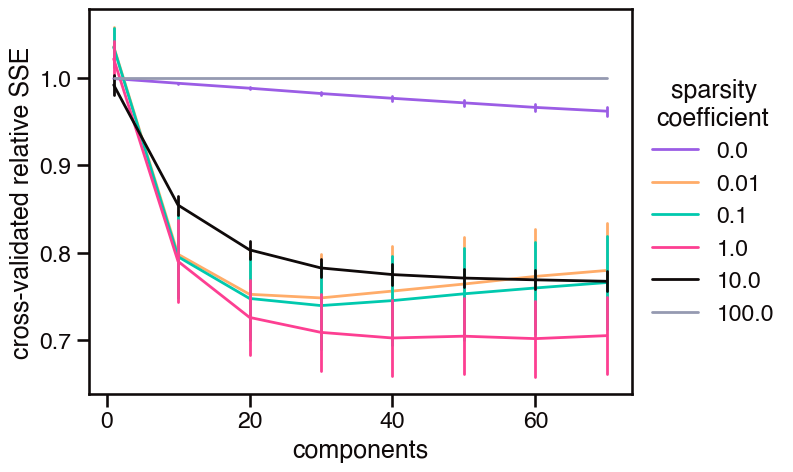

syn


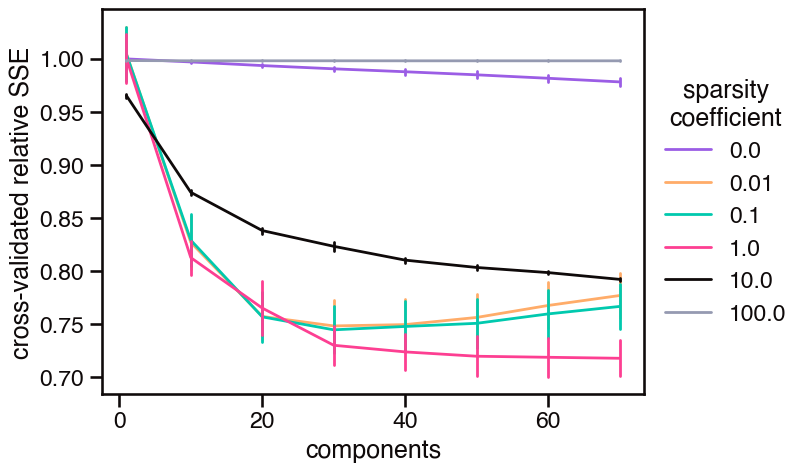

In [241]:
# look at relative_sse vs rank

for genus in ['pro', 'syn']:
    print(genus)
    results_df = df[df['genus'] == genus]
    results_df = results_df[results_df['modeled_replicate'] != results_df['comparison_replicate']]

    fig, axis = plt.subplots(figsize=(7, 5))
    for i, lamb in enumerate(results_df['lambda'].unique()):
        data_df = results_df[results_df['lambda'] == lamb]
        sns.lineplot(
            x='rank', 
            y='relative_sse', 
            color=sns.color_palette()[i], 
            errorbar='se', 
            err_style='bars', 
            data=data_df,
            ax=axis, 
            label=lamb
    );
    #     sns.scatterplot(
    #         x='rank', 
    #         y='relative_sse', 
    #         style='replicate_pair',
    #         alpha=0.2, 
    #         color=sns.color_palette()[i], 
    #         data=data_df, 
    #         ax=axis, 
    #         legend=False
    #     );
    plt.xlabel('components')
    plt.ylabel('cross-validated relative SSE')
    plt.legend(title='\t sparsity\ncoefficient', alignment='center', loc='center left', bbox_to_anchor=(1, .5));
    plt.savefig('{}-sse-v-rank.png'.format(genus), bbox_inches='tight')
    plt.show()


pro


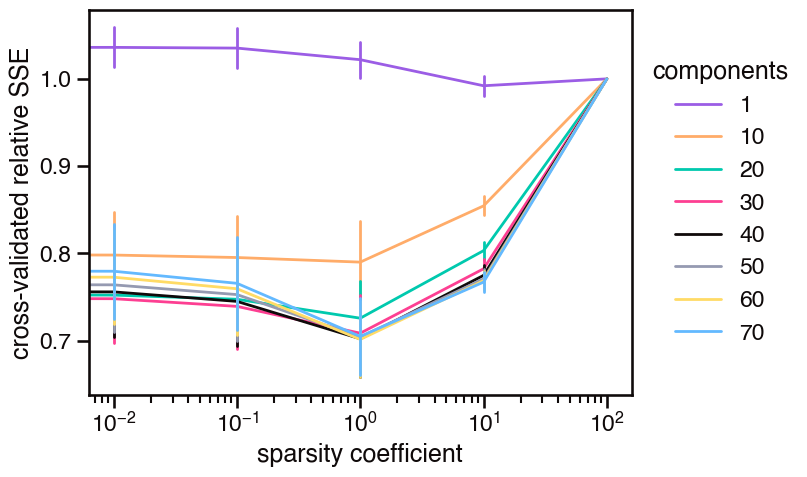

syn


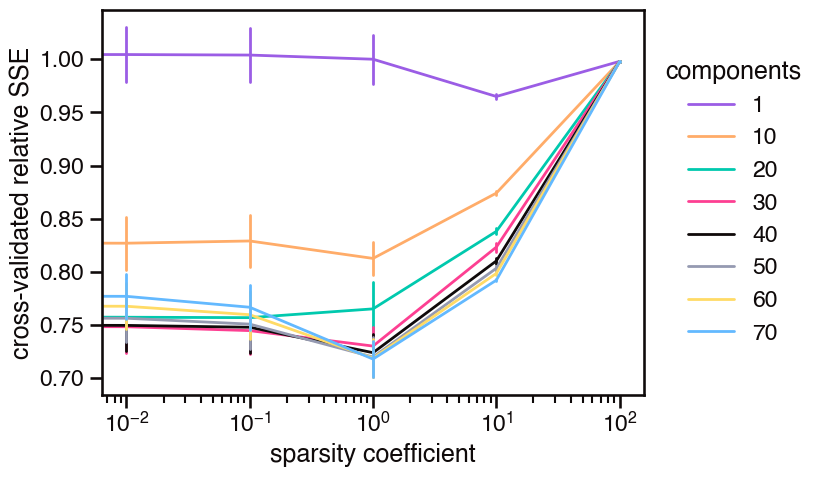

In [245]:
# look at relative_sse vs lambda

for genus in ['pro', 'syn']:
    print(genus)
    results_df = df[df['genus'] == genus]
    results_df = results_df[results_df['modeled_replicate'] != results_df['comparison_replicate']]

    fig, axis = plt.subplots(figsize=(7, 5))
    for i, rank in enumerate(results_df['rank'].unique()):
        data_df = results_df[results_df['rank'] == rank]
        sns.lineplot(
            x='lambda', 
            y='relative_sse', 
            color=sns.color_palette()[i], 
            errorbar='se', 
            err_style='bars', 
            data=data_df,
            ax=axis, 
            label=rank
        );
    #     sns.scatterplot(
    #         x='lambda', 
    #         y='relative_sse', 
    #         style='replicate_pair',
    #         alpha=0.2, 
    #         color=sns.color_palette()[i], 
    #         data=data_df, 
    #         ax=axis, 
    #         legend=False
    #     );
    plt.xscale('log', base=10);
    plt.xlabel('sparsity coefficient')
    plt.ylabel('cross-validated relative SSE')
    plt.legend(title='components', loc='center left', bbox_to_anchor=[1, 0.5]);
    plt.savefig('{}-sse-v-lambda.png'.format(genus), bbox_inches='tight')
    plt.show()


In [249]:
df.head()

,bootstrap_id,rank,lambda,modeled_replicate,comparison_replicate,replicate_pair,n_components,mean_gene_sparsity,relative_sse,fms_cv,css_cv_factor0,scss_cv_factor0,genus
7920,0,1,0.0,A,A,"A, A",1,5508.0,0.998605,NaN,NaN,NaN,pro
7921,0,1,0.0,A,B,"A, B",1,5508.0,0.999649,0.347542,0.924010,1.0,pro
7922,0,1,0.0,A,C,"A, C",1,5508.0,0.999355,0.300203,0.739601,1.0,pro
7923,0,1,0.0,B,A,"B, A",1,5508.0,0.999381,NaN,NaN,NaN,pro
7924,0,1,0.0,B,B,"B, B",1,5508.0,0.998622,NaN,NaN,NaN,pro


pro


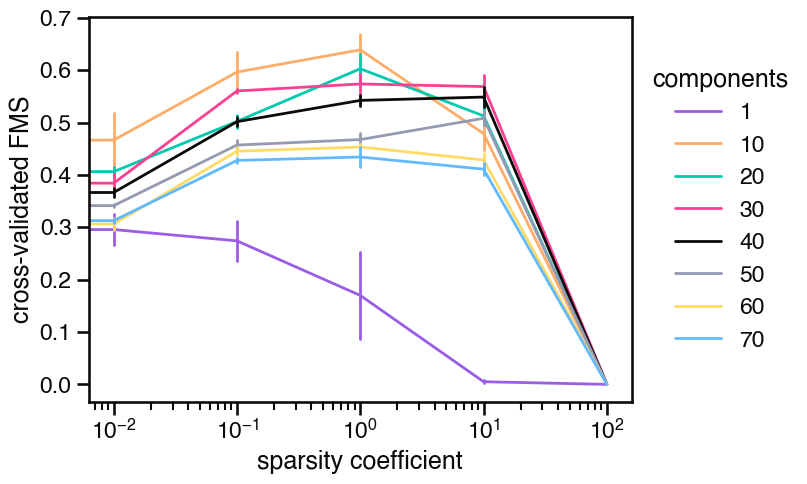

syn


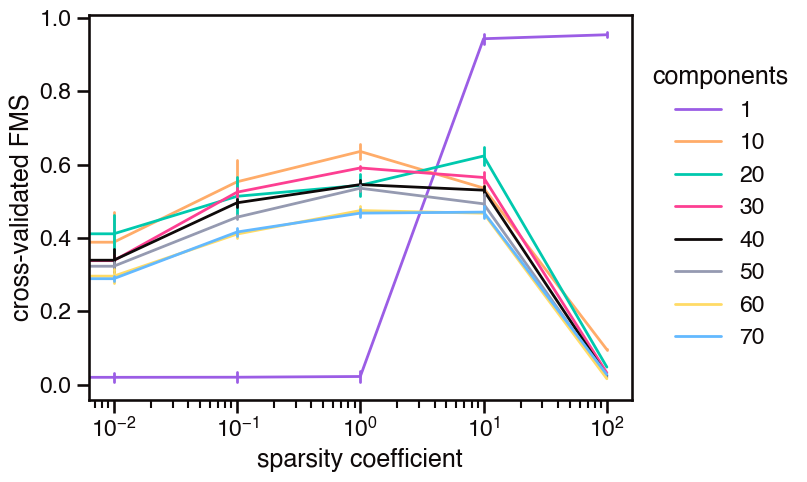

In [252]:
# look at fms vs lambda

for genus in ['pro', 'syn']:
    print(genus)
    results_df = df[df['genus'] == genus]
    results_df = results_df[results_df['modeled_replicate'] != results_df['comparison_replicate']]

    fig, axis = plt.subplots(figsize=(7, 5))
    for i, rank in enumerate(results_df['rank'].unique()):
        data_df = results_df[results_df['rank'] == rank]
        sns.lineplot(
            x='lambda', 
            y='fms_cv', 
            color=sns.color_palette()[i], 
            errorbar='se', 
            err_style='bars', 
            data=data_df,
            ax=axis, 
            label=rank
        );
    #     sns.scatterplot(
    #         x='lambda', 
    #         y='fms_cv', 
    #         style='replicate_pair',
    #         color=sns.color_palette()[i], 
    #         alpha=0.2, 
    #         data=data_df, 
    #         ax=axis, 
    #         legend=(i==len(subsets)-1)
    #     );
    plt.xscale('log', base=10);
    plt.xlabel('sparsity coefficient')
    plt.ylabel('cross-validated FMS')
    plt.legend(title='components', loc='center left', bbox_to_anchor=[1, 0.5]);
    plt.savefig('{}-fms-v-lambda.png'.format(genus), bbox_inches='tight')
    plt.show()


pro


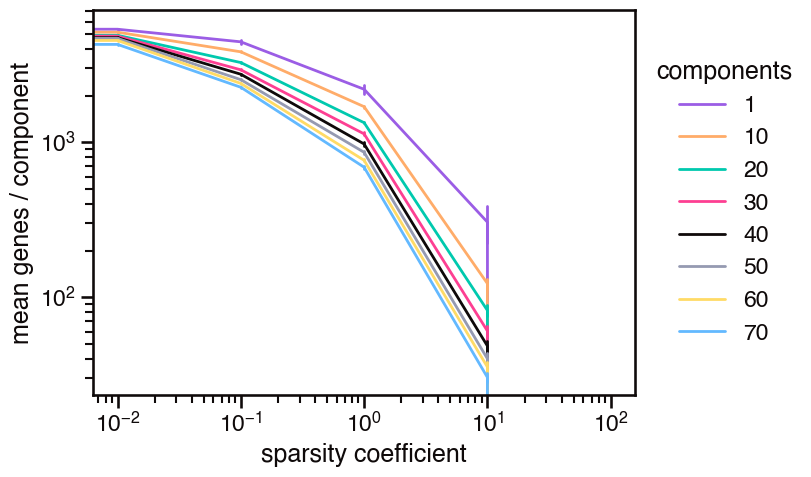

syn


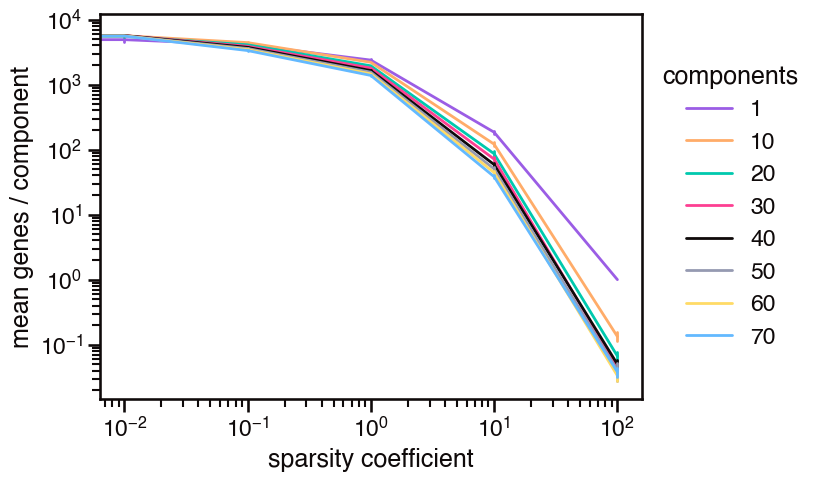

In [247]:
# look at mean_gene_sparsity vs lambda

for genus in ['pro', 'syn']:
    print(genus)
    results_df = df[df['genus'] == genus]
    results_df = results_df[results_df['modeled_replicate'] != results_df['comparison_replicate']]
    
    fig, axis = plt.subplots(figsize=(7, 5))
    for i, rank in enumerate(results_df['rank'].unique()):
        data_df = results_df[results_df['rank'] == rank]
        sns.lineplot(
            x='lambda', 
            y='mean_gene_sparsity', 
            color=sns.color_palette()[i], 
            errorbar='se', 
            err_style='bars', 
            data=data_df,
            ax=axis, 
            label=rank
        );
    #     sns.scatterplot(
    #         x='lambda', 
    #         y='mean_gene_sparsity', 
    #         style='replicate_pair',
    #         alpha=0.2, 
    #         color=sns.color_palette()[i], 
    #         data=data_df, 
    #         ax=axis, 
    #         legend=False
    #     );
    plt.xscale('log', base=10);
    plt.yscale('log', base=10)
    plt.xlabel('sparsity coefficient')
    plt.ylabel('mean genes / component')
    plt.legend(title='components', loc='center left', bbox_to_anchor=[1, 0.5]);
    plt.savefig('{}-genes-per-component-v-lambda.png'.format(genus), bbox_inches='tight')
    plt.show()


# other figures

pro


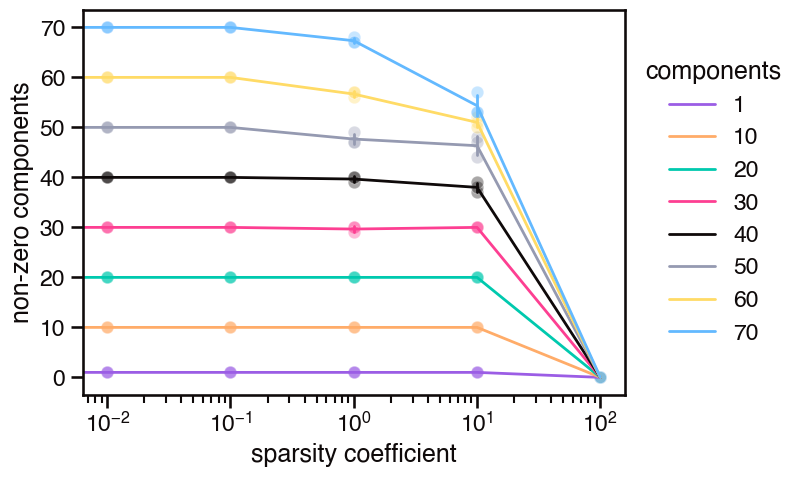

syn


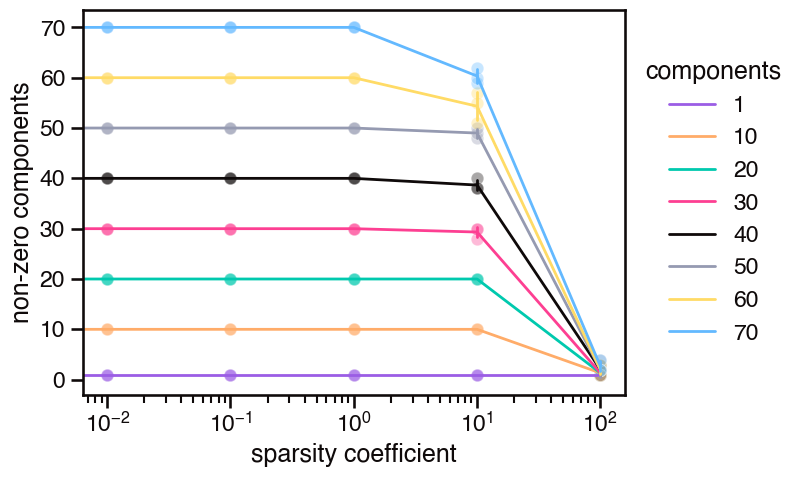

In [232]:
# look at n_components vs lambda

for genus in ['pro', 'syn']:
    print(genus)
    results_df = df[df['genus'] == genus]
    results_df = results_df[results_df['modeled_replicate'] != results_df['comparison_replicate']]

    fig, axis = plt.subplots(figsize=(7, 5))
    for i, rank in enumerate(results_df['rank'].unique()):
        data_df = results_df[results_df['rank'] == rank]
        sns.lineplot(
            x='lambda', 
            y='n_components', 
            color=sns.color_palette()[i], 
            errorbar='sd', 
            err_style='bars', 
            data=data_df,
            ax=axis, 
            label=rank
        );
        sns.scatterplot(
            x='lambda', 
            y='n_components', 
            alpha=0.2, 
            color=sns.color_palette()[i], 
            data=data_df, 
            ax=axis, 
            legend=False
        );
    plt.xscale('log', base=10);
    plt.xlabel('sparsity coefficient')
    plt.ylabel('non-zero components')
    plt.legend(title='components', loc='center left', bbox_to_anchor=[1, 0.5]);
    # plt.savefig('{}-nonzero-components-v-lambda.png'.format(genus), bbox_inches='tight')
    plt.show()


pro


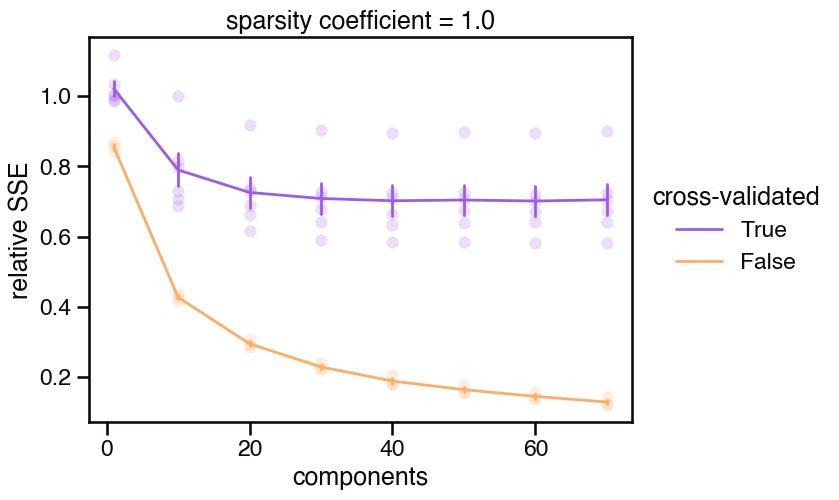

syn


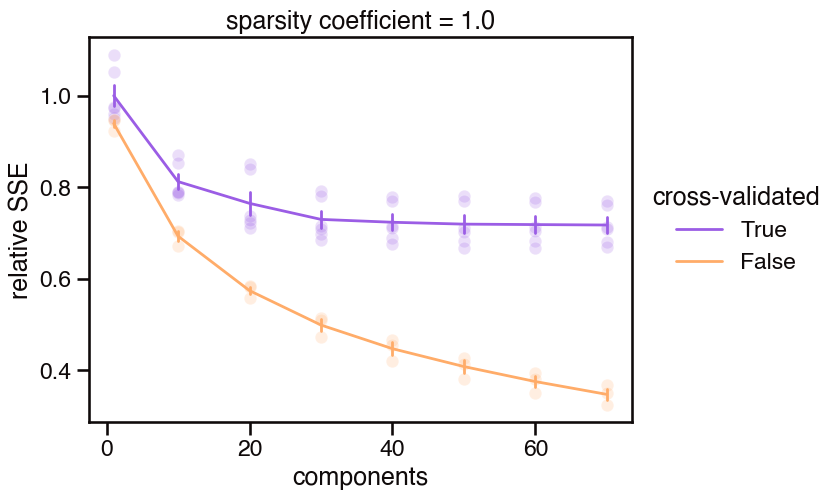

In [248]:
# cross val error vs. self error

lamb = 1.0

for genus in ['pro', 'syn']:
    print(genus)
    results_df = df[df['genus'] == genus]
    results_df = results_df[results_df['lambda'] == lamb]
    results_df['cross-validated'] = (results_df['modeled_replicate'] != results_df['comparison_replicate'])

    fig, axis = plt.subplots(figsize=(7, 5))
    for i, boolean in enumerate([True, False]):
        data_df = results_df[results_df['cross-validated'] == boolean]
        sns.lineplot(
            x='rank', 
            y='relative_sse', 
            color=sns.color_palette()[i], 
            errorbar='se', 
            err_style='bars', 
            data=data_df,
            ax=axis, 
            label=boolean, 
            legend=False
        );
        sns.scatterplot(
            x='rank', 
            y='relative_sse', 
            color=sns.color_palette()[i], 
            alpha=0.2, 
            data=data_df, 
            ax=axis, 
            legend=False
        );
    plt.title('sparsity coefficient = {}'.format(lamb));
    plt.xlabel('components')
    plt.ylabel('relative SSE')
    plt.legend(title='cross-validated', loc='center left', bbox_to_anchor=(1, .5));
    plt.savefig('{}-cv-effect-on-sse-lambda={}.png'.format(genus, lamb), bbox_inches='tight')
    plt.show()


pro


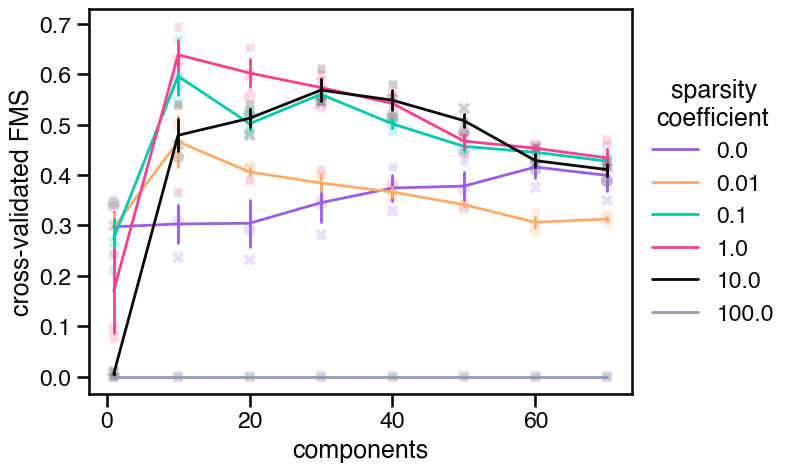

syn


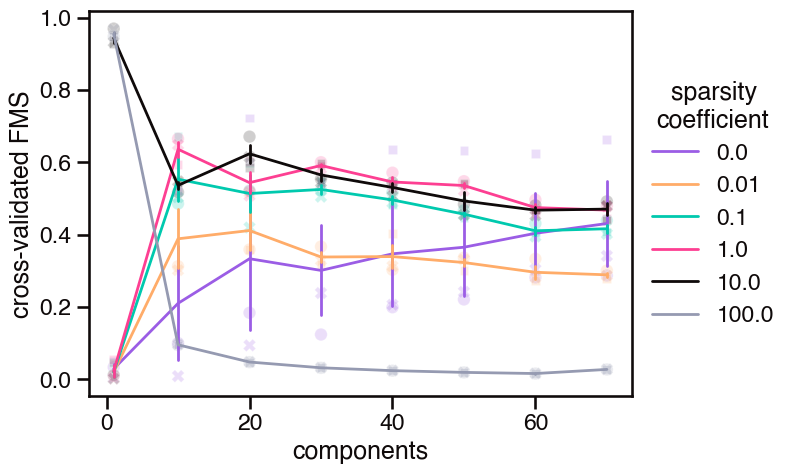

In [234]:
# look at fms vs rank

for genus in ['pro', 'syn']:
    print(genus)
    results_df = df[df['genus'] == genus]
    results_df = results_df[results_df['fms_cv'].notna()]

    fig, axis = plt.subplots(figsize=(7, 5))
    for i, lamb in enumerate(df['lambda'].unique()):
        data_df = results_df[results_df['lambda'] == lamb]
        sns.lineplot(
            x='rank', 
            y='fms_cv', 
            color=sns.color_palette()[i], 
            errorbar='se', 
            err_style='bars', 
            data=data_df,
            ax=axis, 
            label=lamb
        );
        sns.scatterplot(
            x='rank', 
            y='fms_cv', 
            style='replicate_pair',
            color=sns.color_palette()[i], 
            alpha=0.2, 
            data=data_df, 
            ax=axis, 
            legend=False
        );
    plt.xlabel('components')
    plt.ylabel('cross-validated FMS')
    plt.legend(title='\t sparsity\ncoefficient', alignment='center', loc='center left', bbox_to_anchor=(1, .5));
    # plt.savefig('../figures/fms-v-rank-by-lambda.png', bbox_inches='tight')
    plt.show()


# sparsity fine tuning

pro


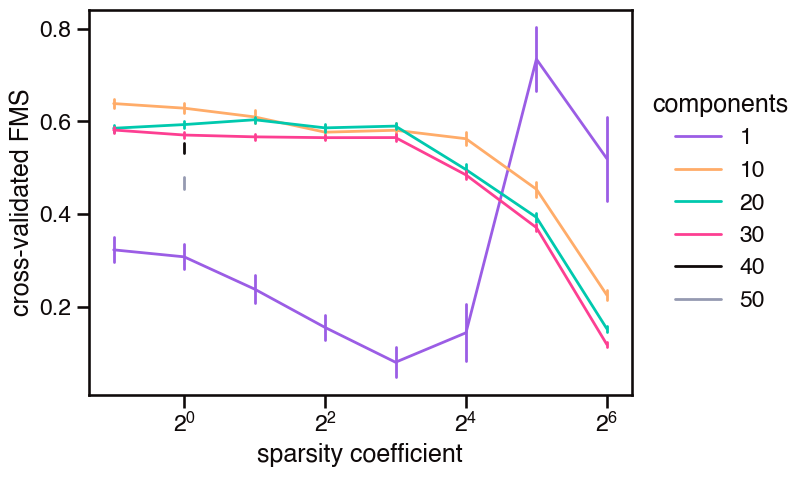

syn


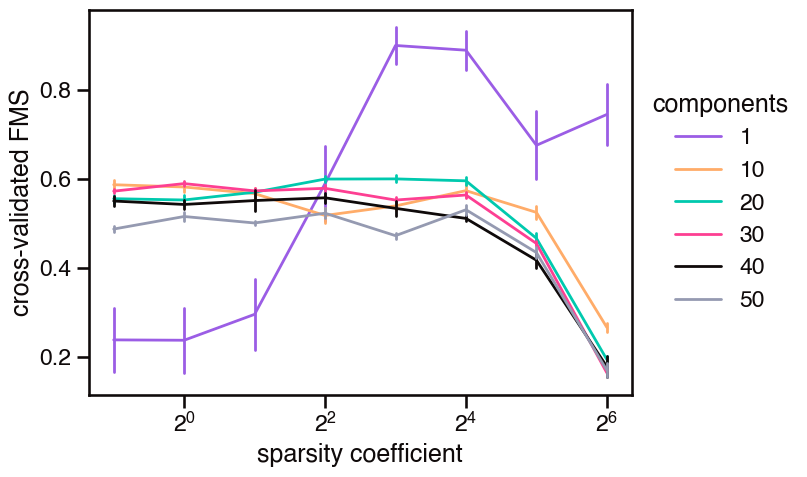

In [238]:
# look at finer-grained sparsity patterns just with the rank=30 models

results_df = combo_df[combo_df['rank'].isin([1, 10, 20, 30, 40, 50])]
results_df = results_df[results_df['lambda'].isin([0.5, 1., 2., 4., 8., 16., 32., 64.])]

for genus in ['pro', 'syn']:
    print(genus)
    working_df = results_df[results_df['genus'] == genus]
    working_df = working_df[working_df['modeled_replicate'] != working_df['comparison_replicate']]

    fig, axis = plt.subplots(figsize=(7, 5))
    for i, rank in enumerate(working_df['rank'].unique()):
        data_df = working_df[working_df['rank'] == rank]
        sns.lineplot(
            x='lambda', 
            y='fms_cv', 
            color=sns.color_palette()[i], 
            errorbar='se', 
            err_style='bars', 
            data=data_df,
            ax=axis, 
            label=rank
        );
    #     sns.scatterplot(
    #         x='lambda', 
    #         y='fms_cv', 
    #         style='replicate_pair',
    #         color=sns.color_palette()[i], 
    #         alpha=0.2, 
    #         data=data_df, 
    #         ax=axis, 
    #         legend=(i==len(subsets)-1)
    #     );
    plt.xscale('log', base=2);
    plt.xlabel('sparsity coefficient')
    plt.ylabel('cross-validated FMS')
    plt.legend(title='components', loc='center left', bbox_to_anchor=[1, 0.5]);
    # plt.savefig('{}-fms-v-lambda-fine-tune.png'.format(genus), bbox_inches='tight')
    plt.show()
